##Previo al modelo

Descarga las librerias necesarias (de colab) y saca los datasets de los repositorios necesarios
(elegir el dataset qué se descargará más abajo y sustituir las rutas donde hagan falta)

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
#!git clone https://github.com/i02romap/D3Sdataset
#!git clone https://github.com/i02romap/yawn_eye_dataset
#!git clone https://github.com/i02romap/distractedDataset
!git clone https://github.com/i02romap/datasetMezcla

Cloning into 'datasetMezcla'...
remote: Enumerating objects: 4763, done.
remote: Total 4763 (delta 0), reused 0 (delta 0), pack-reused 4763
Receiving objects: 100% (4763/4763), 570.49 MiB | 22.77 MiB/s, done.
Updating files: 100% (4767/4767), done.


##Cargar librerias y crear clases para datasets y dataloaders

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import torchvision.models as models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)
print('Timm version', timm.__version__)

System Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
PyTorch version 2.3.0+cu121
Torchvision version 0.18.0+cu121
Numpy version 1.25.2
Pandas version 2.0.3
Timm version 1.0.3


In [ ]:
class DistractionDataset(Dataset):
    #data_dir -> where our data is sitting
    def __init__ (self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__ (self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

##Crear y entrenar modelo

(Elegir modelo aquí e hiperparámetros del entrenamiento más abajo)

In [ ]:
import torch.nn as nn
import timm
import torchvision.models as models

modelo = 2
#1 - mobilenet
#2 - efficientnet
#3 - densenet
#4 - squeezenet
pretrain = 1
#1 - true
#0 - false

class distractedClassifier(nn.Module):
    def __init__(self, num_clases=2):
        super(distractedClassifier, self).__init__()

        if modelo == 1:
          if pretrain == 1:
            self.base_model=timm.create_model('tf_mobilenetv3_large_100', pretrained=True)
            enet_out_size=self.base_model.classifier.in_features

            self.base_model.classifier = nn.Sequential(
              nn.Linear(enet_out_size, num_clases)
            )
          else:
            self.base_model=timm.create_model('tf_mobilenetv3_large_100', pretrained=False)
            enet_out_size=self.base_model.classifier.in_features

            self.base_model.classifier = nn.Sequential(
              nn.Linear(enet_out_size, num_clases)
            )


        if modelo == 2:
          if pretrain == 1:
            self.base_model=timm.create_model('efficientnet_b0', pretrained=True)
            enet_out_size=self.base_model.classifier.in_features

            self.base_model.classifier = nn.Sequential(
              nn.Linear(enet_out_size, num_clases)
            )
          else:
            self.base_model=timm.create_model('efficientnet_b0', pretrained=False)
            enet_out_size=self.base_model.classifier.in_features

            self.base_model.classifier = nn.Sequential(
              nn.Linear(enet_out_size, num_clases)
            )


        if modelo == 3:
          if pretrain == 1:
            self.base_model=timm.create_model('efficientnet_b0', pretrained=True)
            enet_out_size=self.base_model.classifier.in_features

            self.base_model.classifier = nn.Sequential(
              nn.Linear(enet_out_size, num_clases)
            )
          else:
            self.base_model=timm.create_model('efficientnet_b0', pretrained=False)
            enet_out_size=self.base_model.classifier.in_features

            self.base_model.classifier = nn.Sequential(
              nn.Linear(enet_out_size, num_clases)
            )


        if modelo == 4:
          if pretrain == 1:
            self.base_model = models.squeezenet1_1(pretrained=True)
            for param in self.base_model.parameters():
                param.requires_grad = False
            self.base_model.classifier[1] = nn.Conv2d(512, num_clases, kernel_size=1)
            self.base_model.num_classes = num_clases
          else:
            self.base_model = models.squeezenet1_1(pretrained=False)
            for param in self.base_model.parameters():
                param.requires_grad = False
            self.base_model.classifier[1] = nn.Conv2d(512, num_clases, kernel_size=1)
            self.base_model.num_classes = num_clases

    def forward(self, x):
       return self.base_model(x)


In [ ]:
model=distractedClassifier(num_clases=2)

####bucle de entrenamiento

(Modificar hiperparametros de training aquí)

loss function y optimizador

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

train_dir='/content/datasetMezcla/train'
valid_dir='/content/datasetMezcla/validation'
test_dir='/content/datasetMezcla/test'

train_dataset = DistractionDataset(train_dir, transform)
valid_dataset = DistractionDataset(valid_dir, transform)
test_dataset = DistractionDataset(test_dir, transform)

train_dataloader = DataLoader(train_dataset , batch_size = 32 , shuffle = True)
valid_dataloader = DataLoader(valid_dataset , batch_size = 32 , shuffle = True)
test_dataloader = DataLoader(test_dataset , batch_size = 32 , shuffle = True)

In [ ]:
def calculate_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

entrenamiento

In [ ]:
train_losses, val_losses = [],[]
train_accs, val_accs= [] , []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = distractedClassifier(num_clases=2)
model.to(device)

loss_funct = nn.CrossEntropyLoss()
optimizador = optim.Adam(model.parameters(), lr=0.002)

cuda:0


In [ ]:
num_epochs=1


for epoch in range(num_epochs):
  model.train()
  running_loss=0.0
  for images, labels in tqdm(train_dataloader, desc='Training loop'):
    images, labels = images.to(device), labels.to(device)

    optimizador.zero_grad()
    outputs=model(images)
    loss = loss_funct(outputs, labels)
    loss.backward()
    optimizador.step()
    running_loss+=loss.item()*labels.size(0)
  train_loss= running_loss/len(train_dataloader.dataset)
  train_losses.append(train_loss)
  train_acc = calculate_accuracy(model, train_dataloader, device)
  train_accs.append(train_acc)

  model.eval()
  running_loss=0.0
  with torch.no_grad():
    for images, labels in tqdm(valid_dataloader, desc='Validation loop'):
      images, labels = images.to(device), labels.to(device)

      outputs=model(images)
      loss=loss_funct(outputs, labels)
      running_loss+=loss.item()*labels.size(0)
  val_loss=running_loss/len(valid_dataloader.dataset)
  val_losses.append(val_loss)
  val_acc = calculate_accuracy(model, valid_dataloader, device)
  val_accs.append(val_acc)

  print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}, Training accuracy: {train_acc}, Validation accuracy: {val_acc}")

Training loop:   0%|          | 0/104 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 1/1 - Train loss: 0.169241441027003, Validation loss: 0.09765932332918542, Training accuracy: 97.99939375568354, Validation accuracy: 97.39336492890995


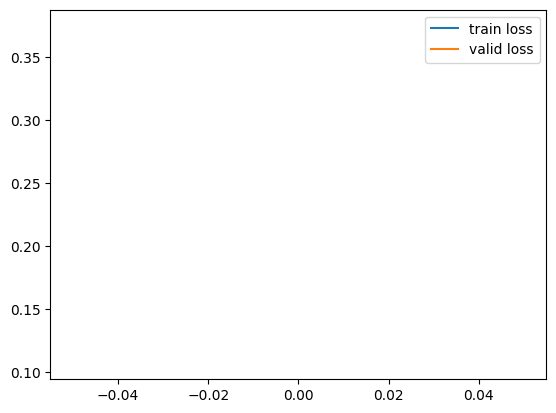

In [ ]:
#visualizar loss
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='valid loss')
plt.legend()
plt.show()

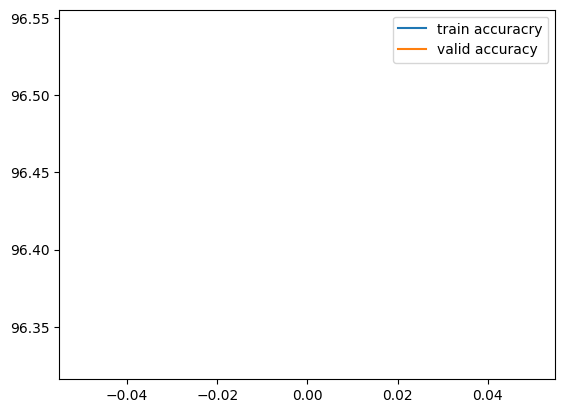

In [ ]:
#visualizar accuracy
plt.plot(train_accs, label='train accuracry')
plt.plot(val_accs, label='valid accuracy')
plt.legend()
plt.show()

#Evaluación del modelo
Obtener la matriz de confusión y accuracy

In [ ]:
# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        probabilities = probabilities[:, :2]
    return probabilities.cpu().numpy().flatten()




In [ ]:
test_images = glob('/content/datasetMezcla/test/*/*')
clases_reales = []
clases_predichas = []
for item in test_images:
    if item.endswith('.jpg'):
      clases_reales.append(os.path.basename(os.path.dirname(item)))

      original_image, image_tensor = preprocess_image(item, transform)
      probabilities = predict(model, image_tensor, device)
      class_names = dataset.classes

      clases_predichas.append(class_names[np.argmax(probabilities)])

print(clases_reales)
print(clases_predichas)

['Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct', 'Correct'

Matriz de Confusión:
[[199  12]
 [  6 407]]
624
Accuracy del test: 97.11538461538461


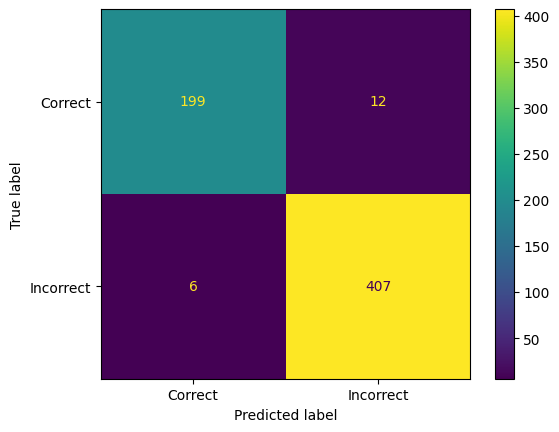

In [ ]:
# Obtener todas las clases únicas
clases = np.unique(clases_reales+clases_predichas)

# Crear la matriz de confusión
confusion = confusion_matrix(clases_reales, clases_predichas, labels=clases)

print("Matriz de Confusión:")
print(confusion)
print(np.sum(confusion))



disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=clases)
disp.plot()


print(f"Accuracy del test: {accuracy_score(clases_reales, clases_predichas)*100}")

#Descargar Modelo

Guardar y descargar el fichero .pth del modelo entrenado

In [ ]:
from google.colab import files
torch.save(model.state_dict(), 'modeloDescarga.pth')

files.download('modeloDescarga.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Guardar el dataset con las carpetas de las clases  
Para datasets que vinieran sin modificar

(se puede hacer esto directamente, solo necesitando hacer la parte de Previo al modelo)

In [ ]:
!zip -r datasetEditado.zip /content/yawn_eye_dataset

  adding: content/yawn_eye_dataset/ (stored 0%)
  adding: content/yawn_eye_dataset/validation/ (stored 0%)
  adding: content/yawn_eye_dataset/validation/Open/ (stored 0%)
  adding: content/yawn_eye_dataset/validation/Open/_323.jpg (deflated 1%)
  adding: content/yawn_eye_dataset/validation/Open/_614.jpg (deflated 1%)
  adding: content/yawn_eye_dataset/validation/Open/_150.jpg (deflated 33%)
  adding: content/yawn_eye_dataset/validation/Open/_488.jpg (deflated 1%)
  adding: content/yawn_eye_dataset/validation/Open/_676.jpg (deflated 69%)
  adding: content/yawn_eye_dataset/validation/Open/_165.jpg (deflated 63%)
  adding: content/yawn_eye_dataset/validation/Open/_516.jpg (deflated 1%)
  adding: content/yawn_eye_dataset/validation/Open/_204.jpg (deflated 2%)
  adding: content/yawn_eye_dataset/validation/Open/_626.jpg (deflated 0%)
  adding: content/yawn_eye_dataset/validation/Open/_602.jpg (deflated 1%)
  adding: content/yawn_eye_dataset/validation/Open/_696.jpg (deflated 75%)
  adding: c

In [ ]:
from google.colab import files
files.download('datasetEditado.zip')


FileNotFoundError: Cannot find file: datasetEditado.zip